# Taiwan GEBCO bathymetry

### Download and plot bathymetry data around Taiwan using Datamesh

Compare bathy changes between the early, 2008 1-arcminute, and the latest, 2025 15-second versions

In [1]:
import cmocean
import warnings
import cartopy.crs as ccrs
from cartopy import feature as cfeature
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors

from oceanum.datamesh import Connector

warnings.filterwarnings("ignore")

## Connect to datamesh
Define your datamesh token in evironment variables as DATAMESH_TOKEN or insert into argument below.

In [2]:
conn = Connector(token=None)

Using datamesh API version 0
You are using version 1.0.12 of oceanum_python which is the latest version available.


## Query the data

Load the latest version of the GEBCO data around Taiwan

In [3]:
west = 119.9
south = 21.8
east = 122.2
north = 25.4

dset_2008 = conn.query(
    datasource="gebco_2008",
    variables=["elevation"],
    geofilter={
        "type": "bbox", "geom": [west, south, east, north]},
)

dset_2025 = conn.query(
    datasource="gebco_2025",
    variables=["elevation", "tid"],
    geofilter={
        "type": "bbox", "geom": [west, south, east, north]},
)

dset_2025

<xarray.Dataset> Size: 1MB
Dimensions:    (lat: 864, lon: 552)
Coordinates:
  * lat        (lat) float64 7kB 21.8 21.81 21.81 21.81 ... 25.39 25.39 25.4
  * lon        (lon) float64 4kB 119.9 119.9 119.9 119.9 ... 122.2 122.2 122.2
Data variables:
    elevation  (lat, lon) int16 954kB -2265 -2182 -2072 -2020 ... -346 -349 -343
    tid        (lat, lon) int8 477kB 11 11 11 11 11 11 11 ... 70 70 70 70 70 70
Attributes: (12/39)
    Conventions:                     CF-1.6, ACDD-1.3
    comment:                         The data in the GEBCO_2025 Grid should n...
    creator_email:                   gdacc@seabed2030.org
    creator_name:                    GEBCO through the Nippon Foundation-GEBC...
    creator_type:                    International organisation
    creator_url:                     https://www.gebco.net
    ...                              ...
    source:                          The GEBCO_2025 Grid is the 2025 release ...
    summary:                         The GEBCO_2025 Grid is a continuous, glo...
    title:                           The GEBCO_2025 Grid - a continuous terra...
    _coordinates:                    {"x":"lon","y":"lat"}
    _request_size:                   1442112
    _domain_size:                    476928

## Plotting the bathymetry

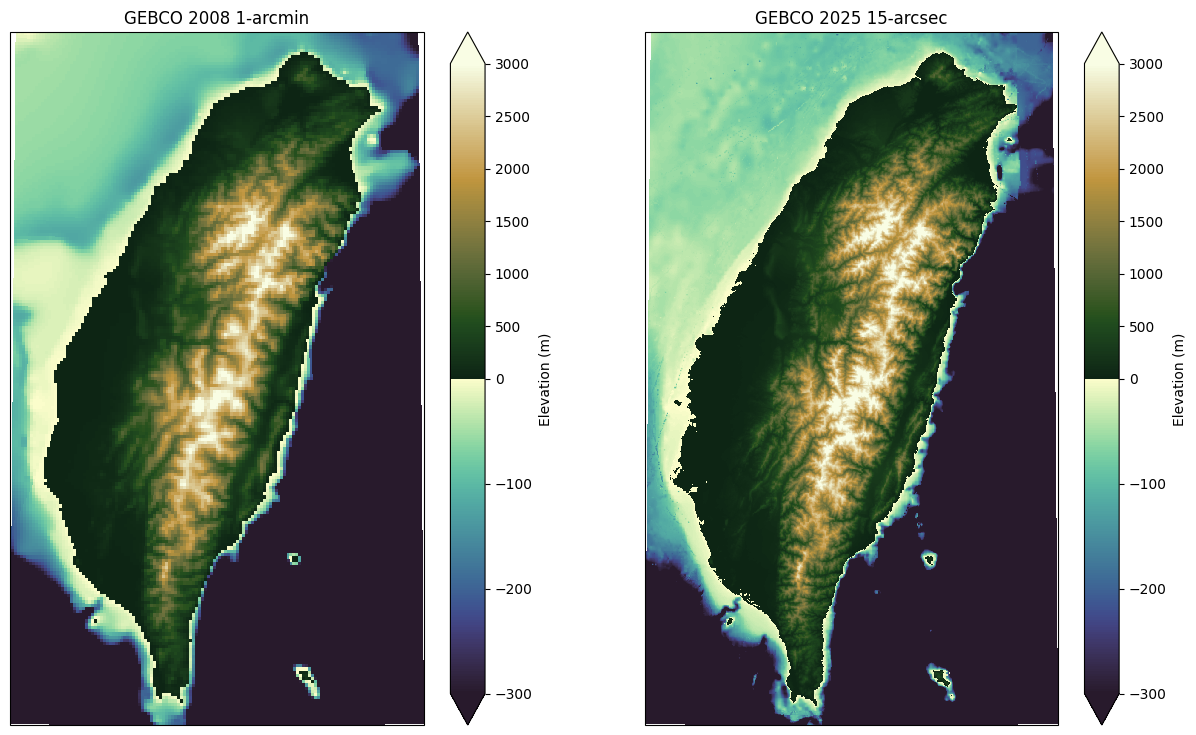

In [4]:
projection = ccrs.TransverseMercator(central_longitude=(float(dset_2025.lon.mean())))
transform = ccrs.PlateCarree()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), subplot_kw={"projection": projection})

# 2008
ax = ax1
dset = dset_2008
dset.elevation.plot(
    ax=ax,
    cmap=cmocean.cm.topo,
    transform=transform,
    norm=colors.TwoSlopeNorm(vmin=-300, vmax=3000, vcenter=0),
    cbar_kwargs={"label": "Elevation (m)", "ticks": [-300, -200, -100, 0, 500, 1000, 1500, 2000, 2500, 3000]}
)
t = ax.set_title("GEBCO 2008 1-arcmin")

# 2025
ax = ax2
dset = dset_2025
dset.elevation.plot(
    ax=ax,
    cmap=cmocean.cm.topo,
    transform=transform,
    norm=colors.TwoSlopeNorm(vmin=-300, vmax=3000, vcenter=0),
    cbar_kwargs={"label": "Elevation (m)", "ticks": [-300, -200, -100, 0, 500, 1000, 1500, 2000, 2500, 3000]}
)
t = ax.set_title("GEBCO 2025 15-arcsec")

## Check the data sources

In [5]:
# Type identifier flags

flag_meanings = dset_2025.tid.attrs["flag_meanings"].split()
flag_meanings = flag_meanings[:15] + ['iceberg_grounding', 'grounded_Argo_float_derived'] + flag_meanings[16:]
flag_values = [int(v) for v in dset_2025.tid.attrs["flag_values"]]

dict(zip(flag_values, flag_meanings))

{0: 'Land',
 10: 'Singlebeam',
 11: 'Multibeam',
 12: 'Seismic',
 13: 'Isolated_sounding',
 14: 'ENC_sounding',
 15: 'Lidar',
 16: 'Optical',
 17: 'Combined',
 40: 'predicted_altimetry',
 41: 'interpolated',
 42: 'contour_charts',
 43: 'contour_ENC',
 44: 'bathymetric_sounding',
 45: 'predicted_airborne',
 46: 'iceberg_grounding',
 47: 'grounded_Argo_float_derived',
 70: 'pre-generated_grid',
 71: 'unknown',
 72: 'steering_point'}

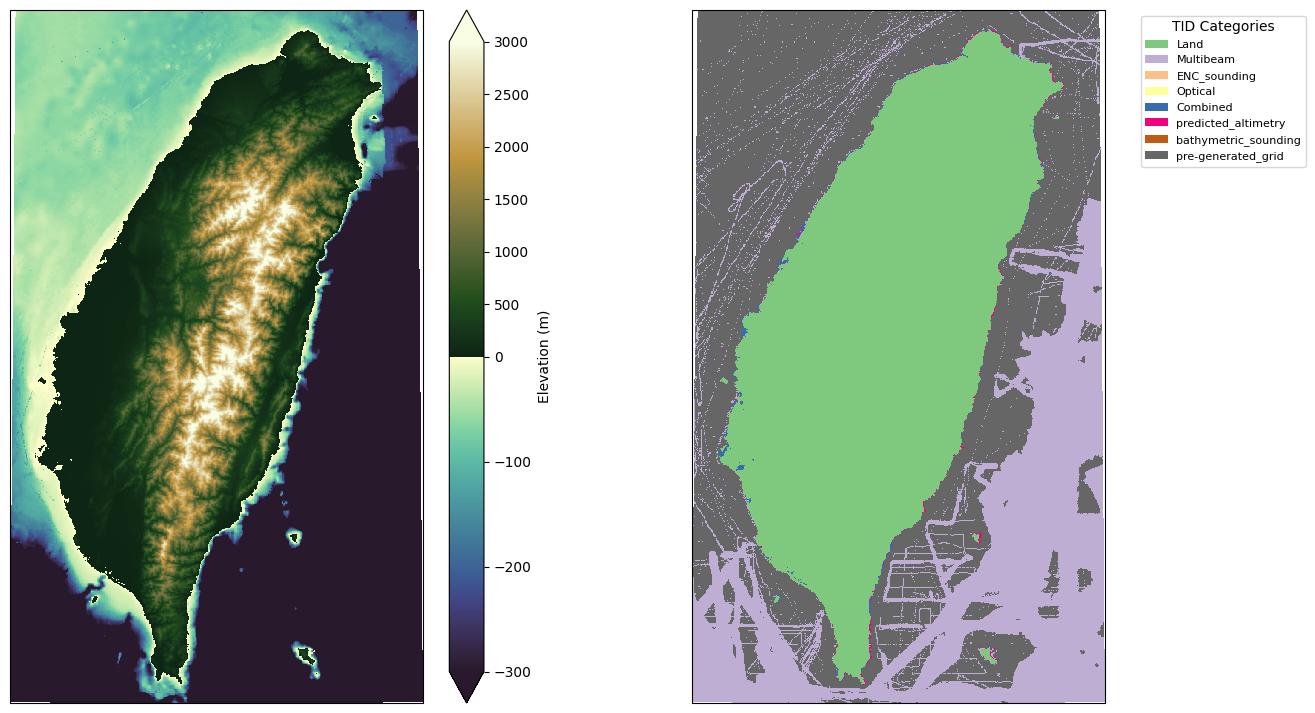

In [ ]:
projection = ccrs.TransverseMercator(central_longitude=(float(dset_2025.lon.mean())))
transform = ccrs.PlateCarree()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), subplot_kw={"projection": projection})

# -------------------------------------
# Depth
# -------------------------------------
ax = ax1
dset_2025.elevation.plot(
    ax=ax,
    cmap=cmocean.cm.topo,
    transform=transform,
    norm=colors.TwoSlopeNorm(vmin=-300, vmax=3000, vcenter=0),
    cbar_kwargs={"label": "Elevation (m)", "ticks": [-300, -200, -100, 0, 500, 1000, 1500, 2000, 2500, 3000]}
)

# -------------------------------------
# Type identifier
# -------------------------------------
cmap = "Accent"
ax = ax2
dset_2025.tid.plot(ax=ax, transform=transform, cmap=cmap, add_colorbar=False)

# Create legend
unique_vals = np.unique(dset_2025.tid.values)
unique_names = [n for v, n in zip(flag_values, flag_meanings) if v in unique_vals]
cmap = plt.cm.get_cmap(cmap, len(unique_vals))
legend_elements = []
for i, name in enumerate(unique_names):
    legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor=cmap(i), label=name))

l = ax.legend(
    handles=legend_elements, 
    loc="upper right",
    bbox_to_anchor=(1.5, 1),
    title="TID Categories",
    fontsize=8,
)